# Variational Autoencoder
___
* see training - loss etc
* compare x and x_dach
* z = 64 dim
* record: noframeskip

In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
import json

/home/dakaun/PycharmProjects/world_model/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dakaun/PycharmProjects/world_model/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dakaun/PycharmProjects/world_model/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dakaun/

In [2]:
from pathlib import Path
path = str(Path(os.getcwd()).parent.parent)

import sys
sys.path.insert(0,path)

from breakout.vae.vae import ConvVAE

In [3]:
path = '/home/dakaun/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200430'
obs_path = '/home/dakaun/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200423/record_noframeskip'
LATENT_DIM = 64
vae_path = path +'/tf_vae'
trainparam_path = path + '/tf_vae/vae_train_param.json'
batch_size=1000

In [4]:
def load_raw_data_list(filelist):
    data_list = []
    action_list = []
    counter = 0
    for i in range(len(filelist)):
        filename = filelist[i]
        raw_data = np.load(os.path.join(obs_path, filename))
        data_list.append(raw_data['obs'])
        action_list.append(raw_data['action'])
        if ((i+1) % 1000 == 0):
            print("loading file", (i+1))
    return data_list, action_list

In [5]:
filelist = os.listdir(obs_path)[:10]
dataset, action_dataset = load_raw_data_list(filelist[0:10])
dataset[0].shape

(1000, 64, 64, 3)

## Compare Input and Output of VAE

In [6]:
vae = ConvVAE(z_size=64,
              batch_size=batch_size,
              learning_rate=0.0001,
              kl_tolerance=0.5,
              is_training=False,
              reuse=False,
              gpu_mode=True)
vae.load_json(os.path.join(vae_path,'vae.json'))

obs = dataset[5]
z = vae.encode(obs) 
z_dec = vae.decode(z)

INFO:tensorflow:Model using gpu.


In [7]:
obs = np.array(obs, dtype=np.float32)

In [8]:
def plot_results(n,frame_nb, obs, z_dec):
    
    n_plots = n * 2
    i = 1
    while i < n_plots + 1:
        if i % 2 == 1:
            plt.subplot(n,2,i)
            plt.title(f"{i},{frame_nb}")
            plt.imshow(obs[frame_nb])
            plt.axis('off')
        else:
            plt.subplot(n,2,i)
            plt.title(f"{i},{frame_nb}")
            plt.imshow(z_dec[frame_nb])
            frame_nb += 1
            plt.axis('off')
        i += 1
    plt.show()    
    

In [14]:
z_dec.max()

0.891252

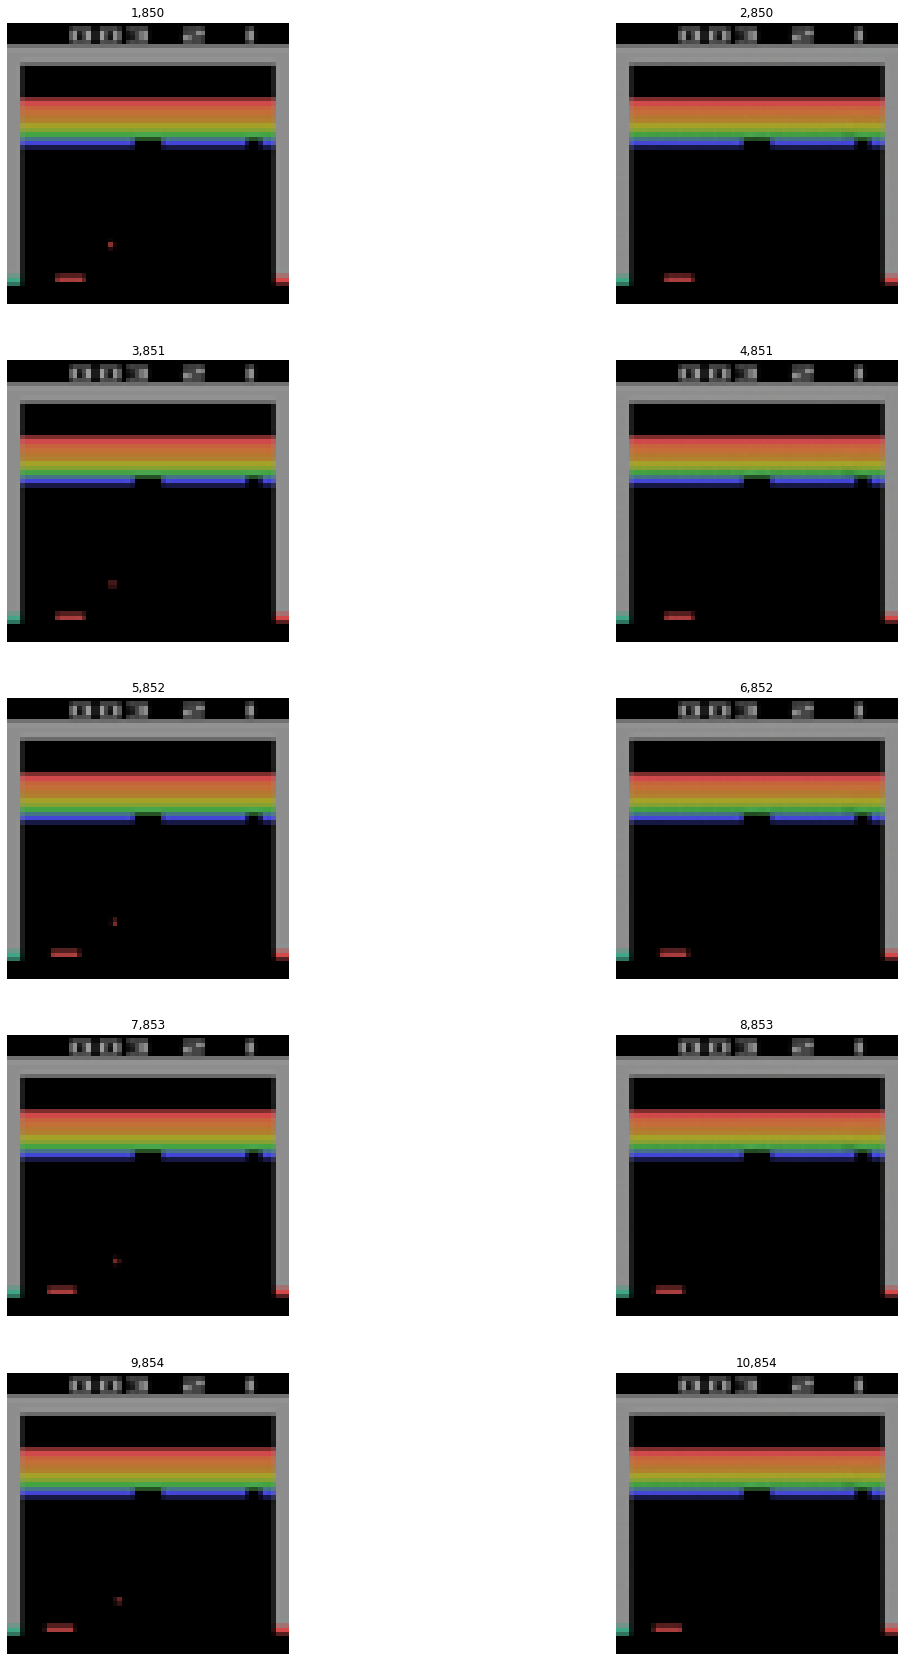

In [14]:
plt.figure(figsize=(20,30))
plot_results(n=5, frame_nb=850,obs=obs, z_dec=z_dec)

### Sample z from normal distribution

In [16]:
vae = ConvVAE(z_size=64,
              batch_size=16,
              learning_rate=0.0001,
              kl_tolerance=0.5,
              is_training=False,
              reuse=False,
              gpu_mode=True)
vae.load_json(os.path.join(vae_path,'vae.json'))

INFO:tensorflow:Model using gpu.


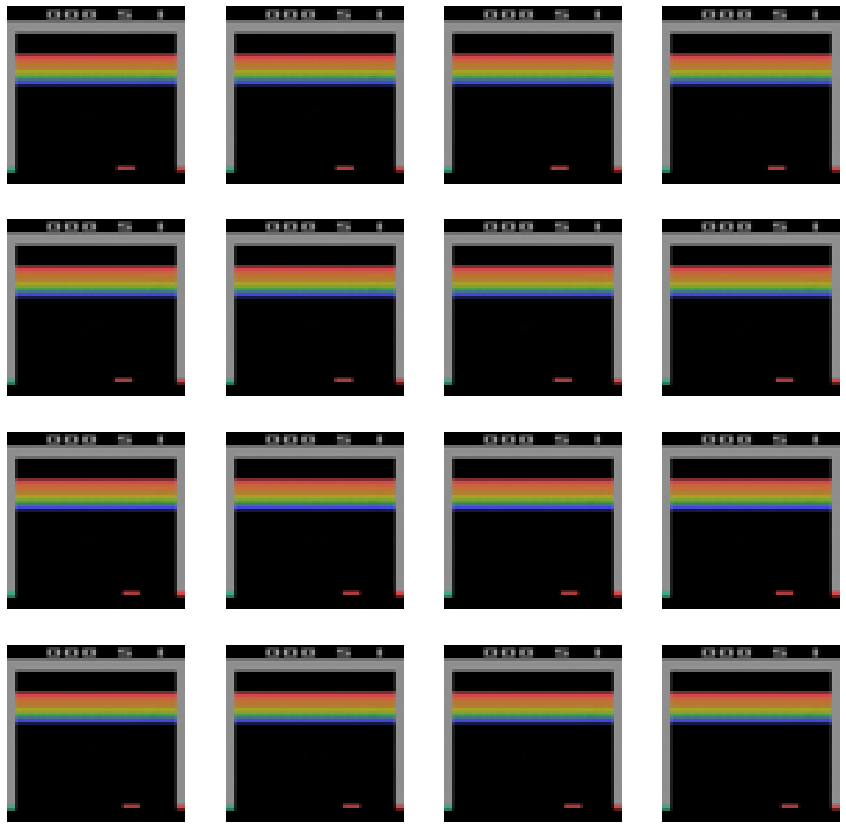

In [17]:
# z from normal distrib
num_examples_to_generate = 16
random_vec_for_generation = np.random.normal(size=(num_examples_to_generate, LATENT_DIM)) 
#tf.random_normal(shape=(num_examples_to_generate, LATENT_DIM))
#z_dec = vae.decode(random_vec_for_generation)
fig = plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(z_dec[i, :, :, :])
    plt.axis('off')
plt.show()

## Z distribution

In [18]:
z[0].shape

(64,)

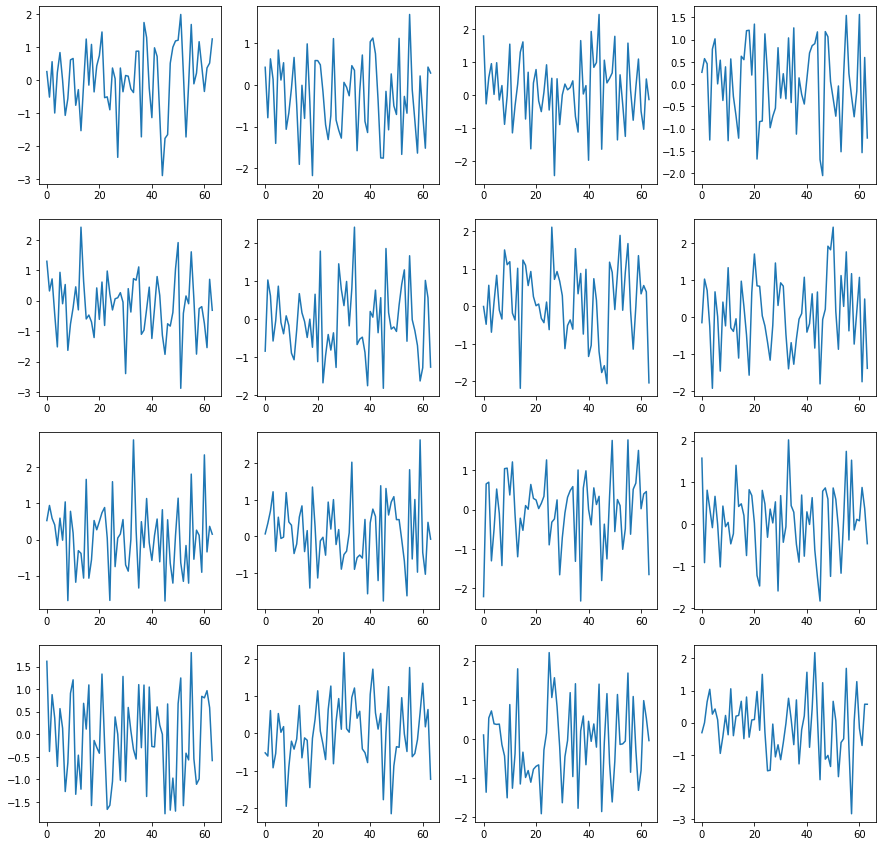

In [20]:
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.plot(z[i].reshape(64))

## Compare Mu and LogVar

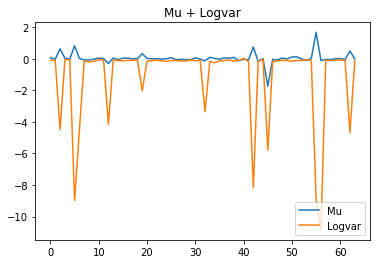

[ 1  2  5  6  7  8  9 12 14 15 19 20 21 23 24 25 26 27 28 30 32 33 34 35
 38 39 41 42 43 45 46 47 49 50 52 54 55 56 58 62 63]
41


In [21]:
obs = dataset[0]
mu, logvar = vae.encode_mu_logvar(obs)
mu.shape
plt.title('Mu + Logvar')
plt.plot(mu[0], label='Mu')
plt.plot(logvar[0], label = 'Logvar')
plt.legend(loc='lower right')
plt.show()
info_var = np.where(abs(logvar[0])>0.1)
print(info_var[0])
print(len(info_var[0]))

## See Training Param

In [25]:
train_param = []
filelist_param = os.listdir(vae_path)
filelist_param.sort()
for file in filelist_param:
    if 'vae_train' in file:
        print(file)
        with open(vae_path + '/' + file, 'r') as filen:
            params = json.load(filen)
        train_param.append(params)

vae_train_param_230420.json
vae_train_param_2304201.json
vae_train_param_2304202.json
vae_train_param_2304203.json
vae_train_param_2304204.json
vae_train_param_2304205.json
vae_train_param_2304206.json
vae_train_param_2304207.json
vae_train_param_2304208.json
vae_train_param_2304209.json


In [30]:
type(train_param[0])

list

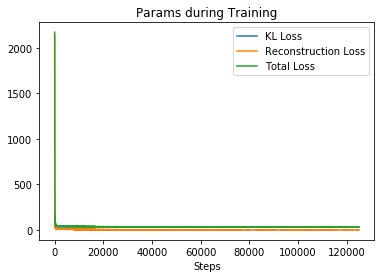

In [33]:
kl_loss = []
r_loss = []
train_loss = []
for item in train_param:
    for subitem in item:
        kl_loss.append(subitem['kl_loss'])
        r_loss.append(subitem['r_loss'])
        train_loss.append(subitem['train_loss'])

plt.plot(kl_loss, label='KL Loss')
plt.plot(r_loss, label='Reconstruction Loss')
plt.plot(train_loss, label='Total Loss')
plt.legend(loc='upper right')
plt.xlabel('Steps')
plt.title('Params during Training')
plt.show()

## Video Sequence


In [23]:
import base64
import imageio
import IPython

In [48]:
z_dec[0].shape

(64, 64, 3)

In [23]:
def embed_mp4(filename,video):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [50]:
filename = 'vae_200430.mp4'
with imageio.get_writer(filename, mode='I') as video:    
    for image in range(399):
        video.append_data(np.array(z_dec[image]*255, dtype=np.uint8))
embed_mp4(filename,video)